## AM Diode Demodulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import setup
from yalrf import YalRF, Netlist
from yalrf.Analyses import MultiToneHarmonicBalance
import time

y = YalRF('Diode AM Demodulator')

i1 = y.add_iac('I1', 'nx', 'gnd', ac=5, freq=1e6)
g1 = y.add_gyrator('G1', 'nx', 'nz', 'gnd', 'gnd', 1)

i2 = y.add_iac('I2', 'ny', 'gnd', ac=0.5, freq=10e3)
g2 = y.add_gyrator('G2', 'ny', 'n1', 'nz', 'gnd', 1)

r1 = y.add_resistor('R1', 'n1', 'nd', 50)
r2 = y.add_resistor('R2', 'n2', 'gnd', 5e3)

c1 = y.add_capacitor('C1', 'n2', 'gnd', 2.2e-9)

d1 = y.add_diode('D1', 'nd', 'n2')

d1.options['Is'] = 1e-15
d1.options['N'] = 1
d1.options['Area'] = 1

begin = time.time()

hb = MultiToneHarmonicBalance('HB1', [1e6, 10e3], [20, 10])
hb.options['reltol'] = 1e-3
hb.options['abstol'] = 1e-6

converged, freqs, Vf, _, _ = hb.run(y)

end = time.time()

hb.print_v('n2')
# hb.plot_v('n2')
# plt.show()

print('Running time: {}'.format(end-begin))
print('HB problem size: {}'.format(hb.V.shape))
print('Number of frequency bins: {}'.format(freqs.shape))


[INFO]: YalRF.Analyses.DC: Starting DC analysis.
[INFO]: YalRF.Analyses.DC: Starting nonlinear DC solver ...
[INFO]: YalRF.Analyses.DC: The solver took 1 iterations.
[INFO]: YalRF.Analyses.DC: Finished DC analysis.
Alpha level: 0.1
HB total error: 3.47e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.13999999999999999
HB total error: 6.82e-06
NR number of iterations: 7
HB iteration converged: True

Alpha level: 0.19599999999999998
HB total error: 5.27e-06
NR number of iterations: 8
HB iteration converged: True

Alpha level: 0.2744
HB total error: 5.21e-07
NR number of iterations: 5
HB iteration converged: True

Alpha level: 0.38415999999999995
HB total error: 4.93e-06
NR number of iterations: 4
HB iteration converged: True

Alpha level: 0.5378239999999999
HB total error: 1.28e-06
NR number of iterations: 4
HB iteration converged: True

Alpha level: 0.7529535999999998
HB total error: 5.69e-07
NR number of iterations: 4
HB iteration converged: True

Alpha level

## Plotting quasiperiodic signal

still need to study a way to better plot a widely separated spectrum in the time-domain efficiently (without too much overhead in points)
the algorithm below just oversample the highest frequency (not efficient at all).

In [13]:
vd = hb.get_v('nd')
vout = hb.get_v('n2')

# define time window to be plotted and time-step
T = 200e-6
tstep = 1. / (8. * np.max(freqs))
numpts = int(T / tstep)

t = np.zeros(numpts)
vt = np.zeros(numpts)
vdt = np.zeros(numpts)
for s in range(numpts):
    t[s] = s * tstep
    vt[s] = vout[0].real
    vdt[s] = vd[0].real
    for k in range(1, len(freqs)):
        f = freqs[k]
        vt[s] = vt[s] + vout[k].real * np.cos(2. * np.pi * f * t[s]) - \
                        vout[k].imag * np.sin(2. * np.pi * f * t[s])
        vdt[s] = vdt[s] + vd[k].real * np.cos(2. * np.pi * f * t[s]) - \
                          vd[k].imag * np.sin(2. * np.pi * f * t[s])


(125.0, 150.0)

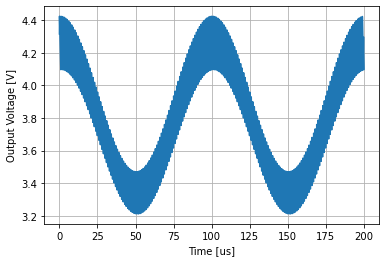

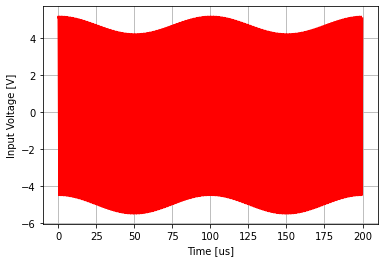

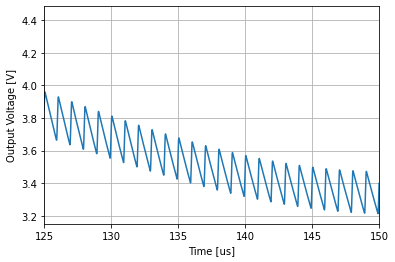

In [18]:
plt.figure()
plt.plot(t * 1e6, vt)
plt.grid()
plt.xlabel('Time [us]')
plt.ylabel('Output Voltage [V]')

plt.figure()
plt.plot(t * 1e6, vdt, 'r')
plt.grid()
plt.xlabel('Time [us]')
plt.ylabel('Input Voltage [V]')

plt.figure()
plt.plot(t * 1e6, vt)
plt.grid()
plt.xlabel('Time [us]')
plt.ylabel('Output Voltage [V]')
plt.xlim(125,150)